In [1]:
# activating the debugger
#%pdb


In [2]:
# necessary backages
import unicodecsv
import numpy as np
from datetime import datetime as dt
from collections import defaultdict # allows you to specify default value
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def read_csv(file_path):
    'takes a path of csv file and retuns list it converted to a list'
    with open(file_path, 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)
enrollments =  read_csv('enrollments.csv')   
daily_engagement =  read_csv('daily_engagement.csv')
project_submissions  = read_csv('project_submissions.csv')

print project_submissions[0]
print daily_engagement[0]

{u'lesson_key': u'3176718735', u'processing_state': u'EVALUATED', u'account_key': u'256', u'assigned_rating': u'UNGRADED', u'completion_date': u'2015-01-16', u'creation_date': u'2015-01-14'}
{u'lessons_completed': u'0.0', u'num_courses_visited': u'1.0', u'total_minutes_visited': u'11.6793745', u'projects_completed': u'0.0', u'acct': u'0', u'utc_date': u'2015-01-09'}


In [4]:
# Takes a date as a string, and returns a Python datetime object. 
# If there is no date given, returns None
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

# Clean up the data types in the enrollments table
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
enrollments[0]

{u'account_key': u'448',
 u'cancel_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'days_to_cancel': 65,
 u'is_canceled': True,
 u'is_udacity': True,
 u'join_date': datetime.datetime(2014, 11, 10, 0, 0),
 u'status': u'canceled'}

In [5]:
# Clean up the data types in the engagement table
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
    
daily_engagement[0]

{u'acct': u'0',
 u'lessons_completed': 0,
 u'num_courses_visited': 1,
 u'projects_completed': 0,
 u'total_minutes_visited': 11.6793745,
 u'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}

In [6]:
# Clean up the data types in the submissions table
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

project_submissions[0]

{u'account_key': u'256',
 u'assigned_rating': u'UNGRADED',
 u'completion_date': datetime.datetime(2015, 1, 16, 0, 0),
 u'creation_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'lesson_key': u'3176718735',
 u'processing_state': u'EVALUATED'}

In [7]:
for engagement_record in daily_engagement:
    engagement_record['account_key'] = engagement_record['acct']
    del(engagement_record['acct'])
daily_engagement[0]['account_key']     

u'0'

In [8]:
def find_unique(table):
    """
    inputs:
        - table : list of dict.
        - key :the primary key of the table
    outputs: 
        the number of unquie keys
    
    """
    unique_set = set()
    for e in table:
        unique_set.add(e['account_key'])
    return unique_set

In [9]:
# the number of enrollments
enrollment_num_rows = len(enrollments)            
enrollment_num_unique_students = len(find_unique(enrollments))
print enrollment_num_rows
print enrollment_num_unique_students

1640
1302


In [10]:
# the number of daily_engagement
engagement_num_rows = len(daily_engagement)            # Replace this with your code
engagement_num_unique_students = find_unique(daily_engagement)

print engagement_num_rows
print len(find_unique(daily_engagement))

136240
1237


In [11]:
# get the number of project_submissions
submission_num_rows = len(project_submissions)
submission_num_unique_students =  find_unique(project_submissions)
print submission_num_rows
print len(submission_num_unique_students)

3642
743


In [12]:
only_in_enrollment = []
for e in enrollments:
    
    student = e['account_key']
    if student not in engagement_num_unique_students:
        only_in_enrollment.append(enrollment)
print len(only_in_enrollment)

71


In [13]:
not_a_day_enrollment = []
for e in enrollments:
    student = e['account_key']
    if student not in engagement_num_unique_students and e["join_date"] != e["cancel_date"] :
        not_a_day_enrollment.append(enrollment)
print len(not_a_day_enrollment)

3


In [14]:
# Create a set of the account keys for all Udacity test accounts
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        udacity_test_accounts.add(enrollment['account_key'])
len(udacity_test_accounts)

6

In [15]:
# Given some data with an account_key field, removes any records corresponding to Udacity test accounts
def remove_udacity_accounts(data):
    non_udacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
    return non_udacity_data

In [16]:
# Remove Udacity test accounts from all three tables
non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagement = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print len(non_udacity_enrollments)
print len(non_udacity_engagement)
print len(non_udacity_submissions)

1622
135656
3634


In [17]:
paid_students = {}
for e in non_udacity_enrollments:
    if not e["is_canceled"] or e["days_to_cancel"] > 7:
        account_key = e['account_key']
        enrollment_date = e['join_date']
        if account_key not in paid_students or enrollment_date > paid_students[account_key]:
            paid_students[account_key] = enrollment_date
print len(paid_students)


995


## Getting Data from First Week


In [18]:
# Takes a student's join date and the date of a specific engagement record,
# and returns True if that engagement record happened within one week
# of the student joining.
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days >= 0

In [19]:
def remove_free_trail_cancels(data):
    new_data = []
    for data_point in data:
        if data_point['account_key'] in paid_students:
            new_data.append(data_point)
    return new_data

In [20]:
paid_enrollments = remove_free_trail_cancels(non_udacity_enrollments)
paid_engagement = remove_free_trail_cancels(non_udacity_engagement)
paid_submissions = remove_free_trail_cancels(non_udacity_submissions)
print len(paid_enrollments)
print len(paid_engagement)
print len(paid_submissions)

1293
134549
3618


In [21]:
# creating a new column for count the number of days student vist the classroom
for rec in paid_engagement:
    if rec['num_courses_visited'] > 0:
        rec["has_visited"] = 1
    else:
        rec["has_visited"] = 0

In [22]:


## Create a list of rows from the engagement table including only rows where
## the student is one of the paid students you just found, and the date is within
## one week of the student's join date.
paid_engagement_in_first_week = []
for e in paid_engagement:
    account_key = e['account_key']
    join_date = paid_students[account_key]
    engagement_date = e['utc_date']
    if within_one_week(join_date, engagement_date):
        paid_engagement_in_first_week.append(e)
print len(paid_engagement_in_first_week)

6919


print list(paid_students)[0]

In [23]:
from collections import defaultdict # allows you to specify default value

engagement_by_account = defaultdict(list)
for engagment_record in paid_engagement_in_first_week:
    account_key = engagment_record["account_key"]
    engagement_by_account[account_key].append(engagment_record)

In [24]:
total_minutes_by_account = {}

for account_key, engagement_for_student in engagement_by_account.items():
    total_minutes = 0
    for engagement_recored in engagement_for_student:
        total_minutes += engagement_recored['total_minutes_visited']
    total_minutes_by_account[account_key] = total_minutes

In [25]:
total_minutes = total_minutes_by_account.values()  


print "mean:", np.mean(total_minutes)
print "std:", np.std(total_minutes)
print "min:", np.min(total_minutes)
print "max:", np.max(total_minutes)

mean: 306.708326753
std: 412.996933409
min: 0.0
max: 3564.7332645


## Debugging Data Analysis Code

In [26]:
student_with_max_minutes = None
max_minutes = 0

for student, total_muintes in engagement_by_account.items():
    if total_muintes > max_minutes:
        max_minutes = total_muintes
        student_with_max_minutes = student
print max, student_with_max_minutes

<built-in function max> 992


In [27]:
#print each engagment_recored for the student
for engagment_recored in paid_engagement_in_first_week:
    if engagment_recored['account_key'] == student_with_max_minutes:
        print engagment_recored
print type(paid_engagement_in_first_week)

{u'lessons_completed': 0, u'num_courses_visited': 3, 'has_visited': 1, u'total_minutes_visited': 39.0104288333, u'projects_completed': 0, 'account_key': u'992', u'utc_date': datetime.datetime(2015, 7, 17, 0, 0)}
{u'lessons_completed': 0, u'num_courses_visited': 0, 'has_visited': 0, u'total_minutes_visited': 0.0, u'projects_completed': 0, 'account_key': u'992', u'utc_date': datetime.datetime(2015, 7, 18, 0, 0)}
{u'lessons_completed': 0, u'num_courses_visited': 0, 'has_visited': 0, u'total_minutes_visited': 0.0, u'projects_completed': 0, 'account_key': u'992', u'utc_date': datetime.datetime(2015, 7, 19, 0, 0)}
{u'lessons_completed': 0, u'num_courses_visited': 0, 'has_visited': 0, u'total_minutes_visited': 0.0, u'projects_completed': 0, 'account_key': u'992', u'utc_date': datetime.datetime(2015, 7, 20, 0, 0)}
{u'lessons_completed': 0, u'num_courses_visited': 0, 'has_visited': 0, u'total_minutes_visited': 0.0, u'projects_completed': 0, 'account_key': u'992', u'utc_date': datetime.datetime(

In [28]:
def group_data(data, key_name="account_key"):
    """takes data and return a dict mapping account key to list of records"""
    grouped_data = defaultdict(list)
    for data_point in data:
        key = data_point[key_name]
        grouped_data[key].append(data_point)
    return grouped_data


In [29]:
# lessons in week
def sum_grouped_items(field_name, data, key_name="account_key"):
    """some the data based on each account"""
    summed_data = {}
    
    grouped_data = group_data(data)
    for key, data_points in grouped_data.items():
        total = 0
        for data_point in data_points:
            total += data_point[field_name]
        summed_data[key] = total
    return summed_data 


In [30]:
def describe_data(field_name, grouped_data, key_name="account_key"):
    """print the summary statistics of the data"""
    data = sum_grouped_items(field_name, grouped_data)
    total_rec = data.values()  
    mean = np.mean(total_rec)
    stand_dev = np.std(total_rec)
    min_value = np.min(total_rec)
    max_value = np.max(total_rec)
    plt.hist(total_rec)    
    return mean, stand_dev, min_value,max_value


(1.636180904522613, 3.0025612998294231, 0, 36)


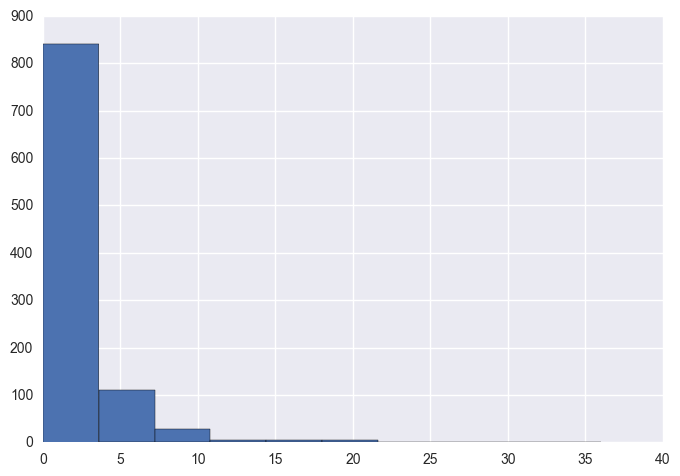

In [31]:
#Lessons Completed in First Week

print describe_data('lessons_completed',  paid_engagement_in_first_week)

(2.8673366834170855, 2.2551980029196814, 0, 7)


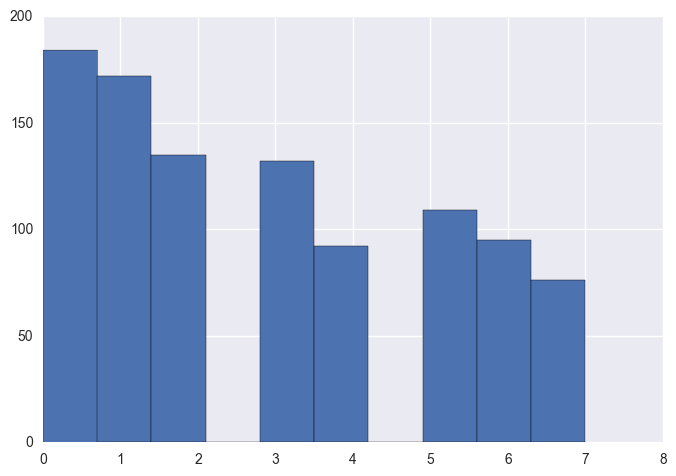

In [32]:
#Number of Visits in the First Week
print describe_data('has_visited',  paid_engagement_in_first_week)

In [33]:
# spliting the student who's first project passed or not

subway_project_lesson_keys = ['746169184', '3176718735']
def is_passed(lesson_keys,data):
    passing_engagement = {}
    non_passing_engagement = {}
    for submition in data:
        account_key = submition['account_key']
        project = submition["lesson_key"] 
        rate = submition["assigned_rating"]
        if (rate == "PASSED" or rate == "DISTINCTION") and project in lesson_keys:
            passing_engagement[account_key] = submition
        elif (rate != "PASSED" or rate == "DISTINCTION") and project in lesson_keys :
            non_passing_engagement[account_key] = submition
    return passing_engagement, non_passing_engagement
            
passing_sub, non_passing_sub = is_passed(subway_project_lesson_keys,paid_submissions)

In [34]:
passing_engagement = []
non_passing_engagement = []
for e in paid_engagement_in_first_week:
    if e["account_key"] in passing_sub:
        passing_engagement.append(e)
    else:
        non_passing_engagement.append(e)
print len(passing_engagement)
print len(non_passing_engagement)

4527
2392


(394.58604648350865, 448.4995193265521, 0.0, 3564.7332644989997)
(143.32647426675584, 269.53861901149509, 0.0, 1768.5227493319999)


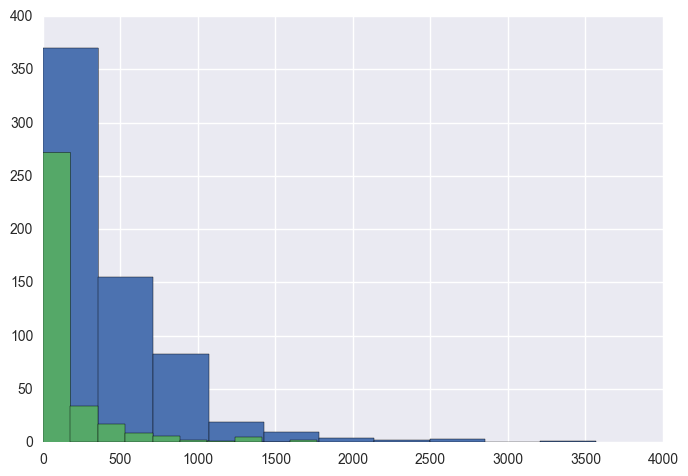

In [35]:
# getting the descriptive statistics for the passed and unPassed students
print describe_data('total_minutes_visited',  passing_engagement)
print describe_data('total_minutes_visited',  non_passing_engagement)



## Making Histograms

The line %matplotlib inline is specifically for IPython notebook, and causes your plots to appear in your notebook rather than a new window. If you are not using IPython notebook, you should not include this line, and instead you should add the line plt.show() at the bottom to show the plot in a new window.

```
data = [1, 2, 1, 3, 3, 1, 4, 2]

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(data)
```

(3.3848531684698608, 2.2588214709184595, 0, 7)
(1.9051724137931034, 1.9057314413619049, 0, 7)


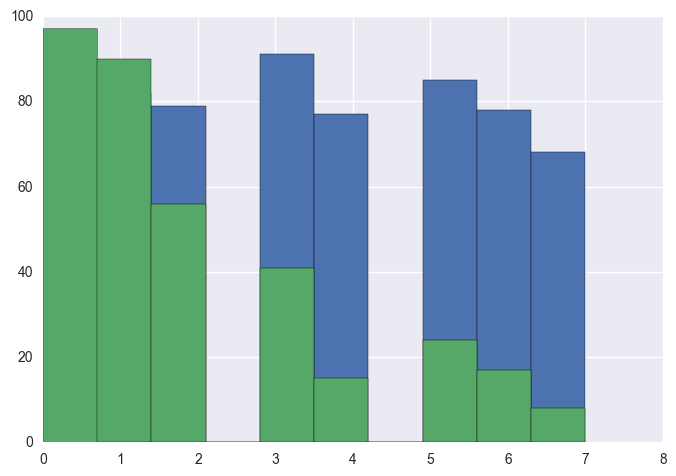

In [36]:
# getting the descriptive statistics for the passed and unPassed students
print describe_data('has_visited',  passing_engagement)
print describe_data('has_visited',  non_passing_engagement)

(2.0525502318392581, 3.1422270555779344, 0, 36)
(0.86206896551724133, 2.5491599418312028, 0, 27)


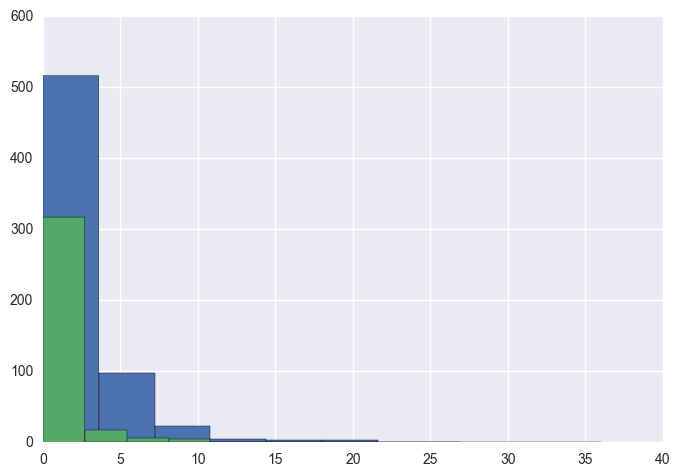

In [37]:
# getting the descriptive statistics for the passed and unPassed students
print describe_data('lessons_completed',  passing_engagement)
print describe_data('lessons_completed',  non_passing_engagement)

(array([ 1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0. ,  0.7,  1.4,  2.1,  2.8,  3.5,  4.2,  4.9,  5.6,  6.3,  7. ]),
 <a list of 10 Patch objects>)

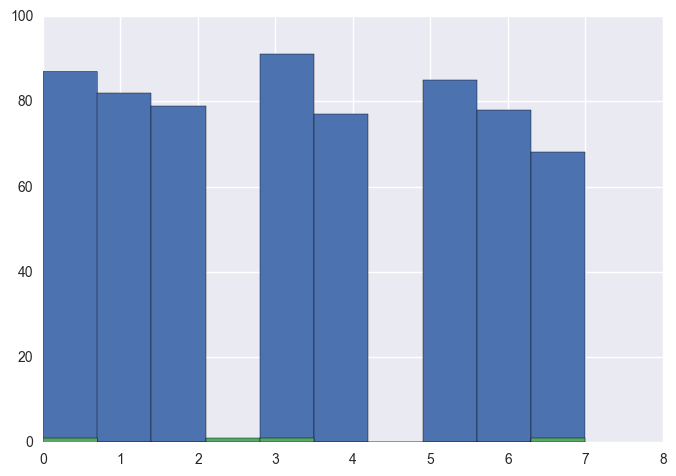

In [38]:
import seaborn as sns
# getting the descriptive statistics for the passed and unPassed students
plt.hist(describe_data('has_visited',  passing_engagement))


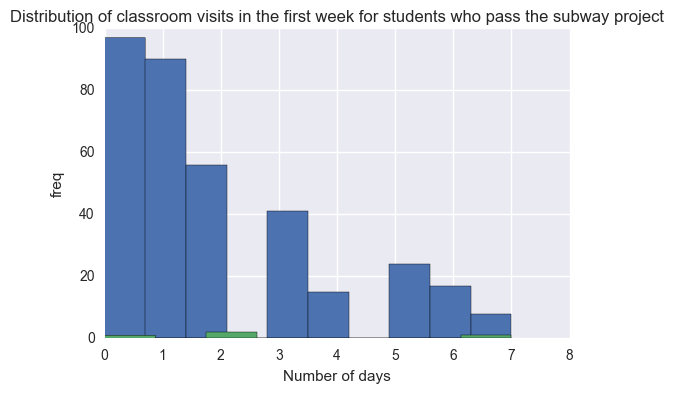

In [44]:
plt.hist(describe_data('has_visited',  non_passing_engagement),bins=8)
plt.xlabel('Number of days')
plt.ylabel('freq')
plt.title('Distribution of classroom visits in the first week ' + 'for students who pass the subway project')